# Рекомендация тарифов

📊 Проект по классификации тарифов оператора мобильной связи 📱

Цель проекта заключается в построении модели классификации, которая сможет анализировать поведение клиентов и предлагать им подходящий новый тариф. У нас уже есть данные о поведении клиентов, которые уже перешли на эти тарифы, и предобработка данных уже выполнена.

🔍 Подготовка данных:
В проекте мы уже произвели предварительную обработку данных, поэтому можем сразу перейти к использованию их для построения модели. Необходимые признаки и целевая переменная уже определены.

📈 Построение модели классификации:
Используя алгоритмы машинного обучения, мы стремимся построить модель, которая способна предсказывать подходящий тариф на основе поведения клиентов. Задача состоит в максимизации точности модели (accuracy), чтобы доля правильных ответов составляла не менее 0.75.

🎯 Оценка точности на тестовой выборке:
Чтобы успешно сдать проект, необходимо самостоятельно проверить точность модели на тестовой выборке. Мы должны достичь значения accuracy не менее 0.75, чтобы считать проект выполненным успешно.

💻 Компиляция и оценка модели:
После построения модели мы компилируем ее, настраиваем параметры и проводим обучение на обучающей выборке. Затем мы оцениваем точность модели на тестовой выборке, чтобы убедиться, что она соответствует требуемому критерию.

📊 Отчет по результатам:
По окончании проекта мы представляем отчет, включающий описание построенной модели, полученную точность (accuracy) и выводы о ее применимости для предсказания подходящих тарифов на основе поведения клиентов.

## Откройте и изучите файл

In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_confusion_matrix

warnings.filterwarnings("ignore")

In [4]:
try:
    df = pd.read_csv('/datasets/users_behavior.csv')

except:
    df = pd.read_csv(r'C:\Users\Barbos-Rapitos\Desktop\practicum\ml_intro\users_behavior.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [6]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [7]:
 #посмотрим на количество строк с разными классами: датасет несбалансирован в сторону 0 (в 2 раза)
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

<AxesSubplot:>

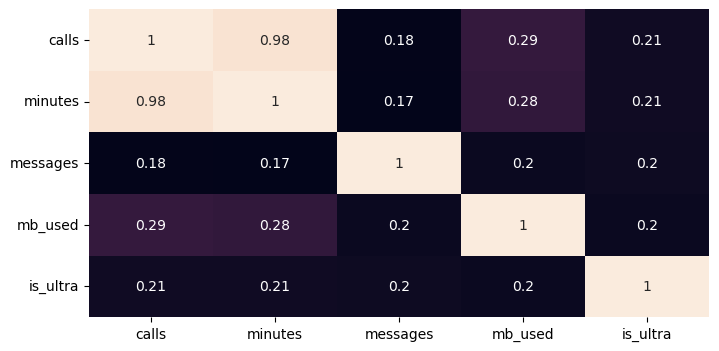

In [8]:
plt.rcParams['figure.figsize'] = (8,4)
sns.heatmap(df.corr(), annot = True, cbar=False)

Две переменных коллинеарны, когда они находятся между собой в линейной зависимости, если коэффициент корреляции более 0,7. Чтобы избавиться от мультиколлинарности, необходимо исключить из модели один из факторов. Например, в эконометрике исключается фактор, который при сильной связи с результатом имеет наибольшую тесноту связи с другими переменными поэтому удалим столбец calls

In [9]:
df = df.drop(columns='calls')

В машинном обучении мультиколлинеарность может стать причиной переобучаемости модели, что приведет к неверному результату. Кроме того, избыточные коэффициенты увеличивают сложность модели машинного обучения, а значит, время ее тренировки возрастает.   
Избавился от мультиколлинеарности удалив столбец calls

## Разбейте данные на выборки

Разделяем исходные данные на обучающую, валидационную и тестовую выборки

In [10]:
df_train, test_part = train_test_split(df, test_size=0.5, random_state=12345, stratify=df['is_ultra'])  # отделяем 50% данных для тренировочной выборки

In [11]:
df_valid, df_test = train_test_split(test_part, test_size=0.5, random_state=12345, stratify=test_part['is_ultra'])  # делим остаток пополам для валидационной и тестовой выборки

In [12]:
df_train['is_ultra'].value_counts()

0    1114
1     493
Name: is_ultra, dtype: int64

In [13]:
# отношение количества строк с 0 к 1
rat = len(df.loc[df['is_ultra']==0])//len(df.loc[df['is_ultra']==1])
rat

2

Создадим новый train датасет методом upsampling:
возьмём все данные с классом 1 
продублируем его rat раз
присоединим к данным класса 0 продублированный класс 1 и перемешаем


In [14]:
df_train_1 = df_train.loc[df_train['is_ultra']==1]
df_train_1 = df_train_1.loc[df_train_1.index.repeat(rat)]
df_train = pd.concat([df_train.loc[df_train['is_ultra']==0], df_train_1]).sample(frac=1)

Посмотрим на новое распределение классов:

In [15]:
df_train['is_ultra'].value_counts()

0    1114
1     986
Name: is_ultra, dtype: int64

In [16]:

features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

In [17]:
display(features_train.shape, target_train.shape, features_valid.shape, target_valid.shape, features_test.shape, target_test.shape)

(2100, 3)

(2100,)

(803, 3)

(803,)

(804, 3)

(804,)

## Исследуйте модели

#### Выбор оптимального параметра max_depth для модели "Решающе дерево" DecisionTreeClassifier

In [18]:
best_model_dt = None
best_result = 0
metrics_dt = pd.DataFrame({'depth':[],
                          'result_train':[]})
metrics_dt_train = pd.DataFrame({'depth':[],
                          'result_valid':[]})
count_i = 0 
for depth in range(1, 15):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth) # обучите модель с заданной глубиной дерева
    model_tree.fit(features_train, target_train) # обучите модель

    predictions = model_tree.predict(features_valid) # получите предсказания модели
    result = accuracy_score(target_valid, predictions) # посчитайте качество модели
    metrics_dt.loc[count_i, 'depth'] = depth
    metrics_dt.loc[count_i, 'result'] = result
    predictions_train = model_tree.predict(features_train)
    result_train = accuracy_score(target_train, predictions_train)
    # metrics_dt.loc[count_i, 'result_valid'] = result_train
    metrics_dt_train.loc[count_i, 'depth'] = depth
    metrics_dt_train.loc[count_i, 'result'] = result_train
    count_i += 1
    if result > best_result:
        best_model_dt = model_tree
        best_result = result
        best_depth = depth
        
print("Accuracy лучшей модели:", best_result, '\nГлубина решающего дерева:', best_depth)

Accuracy лучшей модели: 0.7932752179327521 
Глубина решающего дерева: 7


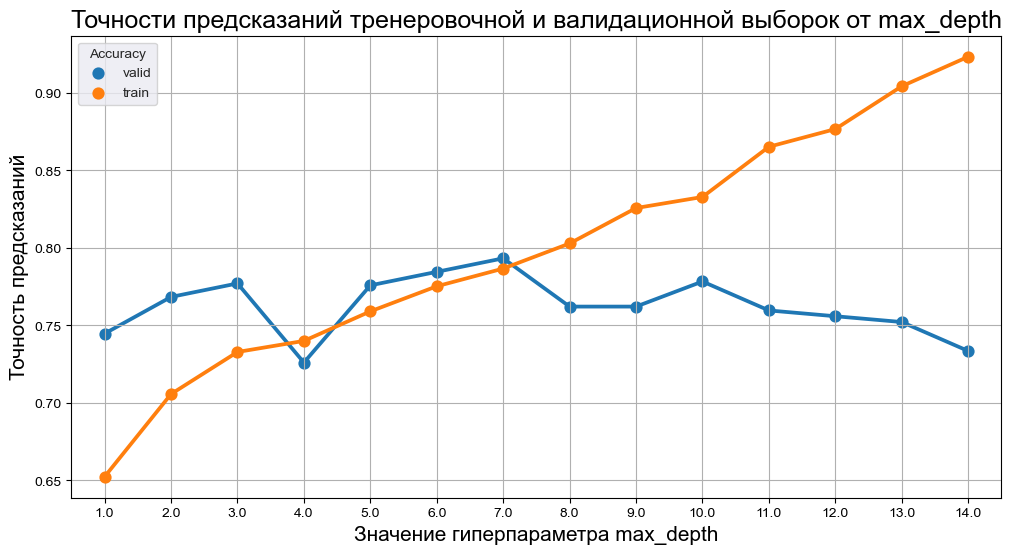

In [19]:
metrics_dt['Accuracy'] = 'valid'
metrics_dt_train['Accuracy'] = 'train'
fig, ax = plt.subplots(figsize=(12, 6))
sns.set_style("darkgrid")
sns.pointplot(data=pd.concat([metrics_dt,metrics_dt_train]), x='depth', y='result', hue='Accuracy', ax=ax)
plt.title('Точности предсказаний тренеровочной и валидационной выборок от max_depth', fontsize=18)
plt.xlabel('Значение гиперпараметра max_depth', fontsize=15)
plt.ylabel('Точность предсказаний', fontsize=15)
plt.grid(True)
plt.show()

На графике видна точка max_depth, когда пошло переобучение модели. 

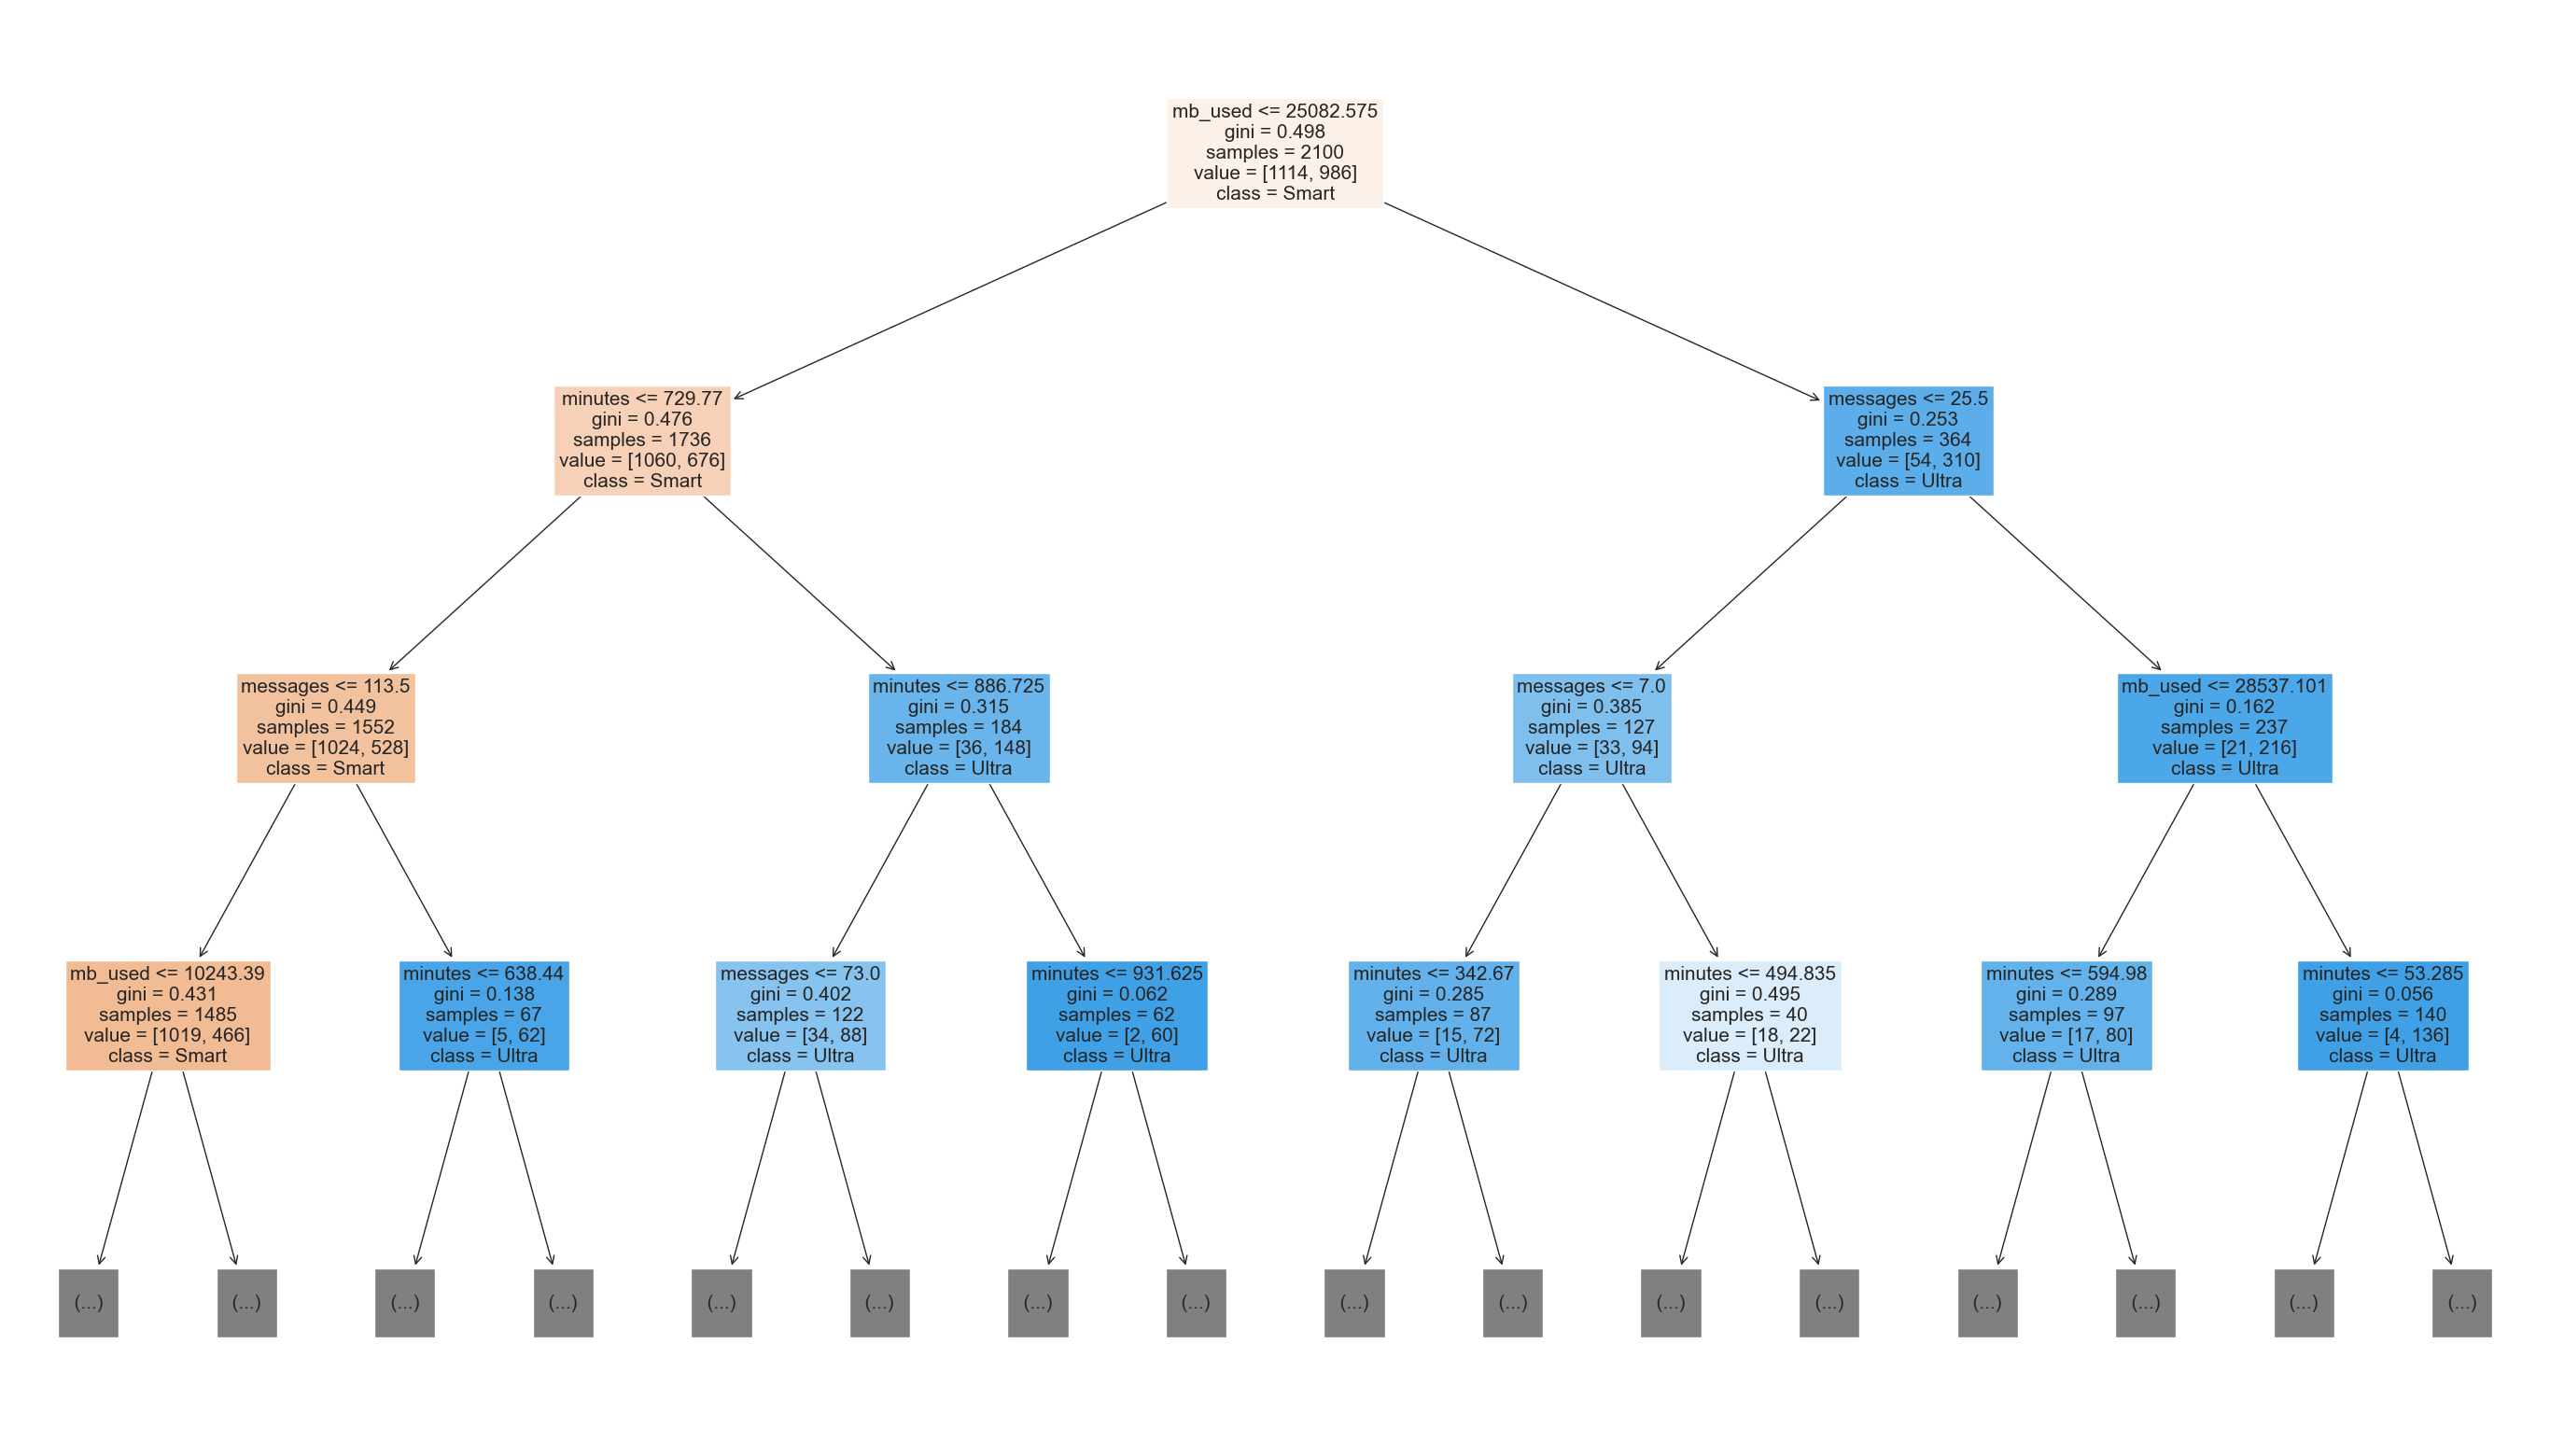

In [40]:
fig = plt.figure(figsize=(35,20))
_ = tree.plot_tree(best_model_dt, 
                feature_names=features_test.columns.values, 
                class_names=['Smart','Ultra'],
                filled=True,
                fontsize = 15,
                max_depth = 3     # Это чтобы прорисовывало 3 уровня, не глубже
                    )

#### Подбор оптимальных параметров n_estimators и max_depth для модели "Случайный лес" RandomForestClassifier

In [52]:
best_model_rf = None
best_result = 0
max_depth = 0
metrics_rf = pd.DataFrame({'n_estimators':[],
                          'max_depth':[],
                          'result':[]})
count_i = 0 

for max_depth in tqdm(list(np.arange(6, 12, step=1))):
    for est in np.arange(50, 135, step=1):
        model_forest = RandomForestClassifier(criterion='entropy', random_state=12345, n_estimators=est, max_depth = max_depth, n_jobs=-1) # обучите модель с заданным количеством деревьев
        model_forest.fit(features_train,target_train) # обучите модель на тренировочной выборке
        predictions = model_forest.predict(features_valid) # получите предсказания модели
        result = accuracy_score(target_valid, predictions) # посчитайте качество модели
        metrics_rf.loc[count_i, 'n_estimators'] = est
        metrics_rf.loc[count_i, 'max_depth'] = max_depth
        metrics_rf.loc[count_i, 'result'] = result
        count_i += 1
        if result > best_result:
            best_max_depth = max_depth
            best_model_rf = model_forest
            best_result = result
            best_est = est

print("Accuracy наилучшей модели на валидационной выборке:", best_result, 'лучший реультат при n_estimators =', best_est, 'max_depth =', best_max_depth)

100%|██████████| 6/6 [01:05<00:00, 10.97s/it]

Accuracy наилучшей модели на валидационной выборке: 0.7995018679950187 лучший реультат при n_estimators = 59 max_depth = 11


In [22]:
# Accuracy наилучшей модели на валидационной выборке: 0.8144458281444583 лучший реультат при n_estimators = 55 max_depth = 8
# 0.8107098381070984 лучший реультат при n_estimators = 73 max_depth = 9

In [23]:
best_model_rf = None
best_result = 0
max_depth = 0
metrics_rf = pd.DataFrame({'n_estimators':[],
                          'max_depth':[],
                          'result':[]})
count_i = 0 

for max_depth in list(np.arange(6, 12, step=1)):
    for est in np.arange(5, 7, step=1):
        model_forest = RandomForestClassifier(criterion='entropy', random_state=12345, n_estimators=est, max_depth = max_depth, n_jobs=-1) # обучите модель с заданным количеством деревьев
        model_forest.fit(features_train,target_train) # обучите модель на тренировочной выборке
        predictions = model_forest.predict(features_valid) # получите предсказания модели
        result = accuracy_score(target_valid, predictions) # посчитайте качество модели
        metrics_rf.loc[count_i, 'n_estimators'] = est
        metrics_rf.loc[count_i, 'max_depth'] = max_depth
        metrics_rf.loc[count_i, 'result'] = result
        count_i += 1
        if result > best_result:
            best_max_depth = max_depth
            best_model_rf = model_forest
            best_result = result
            best_est = est

print("Accuracy наилучшей модели на валидационной выборке:", best_result, 'лучший реультат при n_estimators =', best_est, 'max_depth =', best_max_depth)

Accuracy наилучшей модели на валидационной выборке: 0.7907845579078456 лучший реультат при n_estimators = 6 max_depth = 7


In [34]:
metrics_rf_wide = metrics_rf.pivot('n_estimators','max_depth','result')

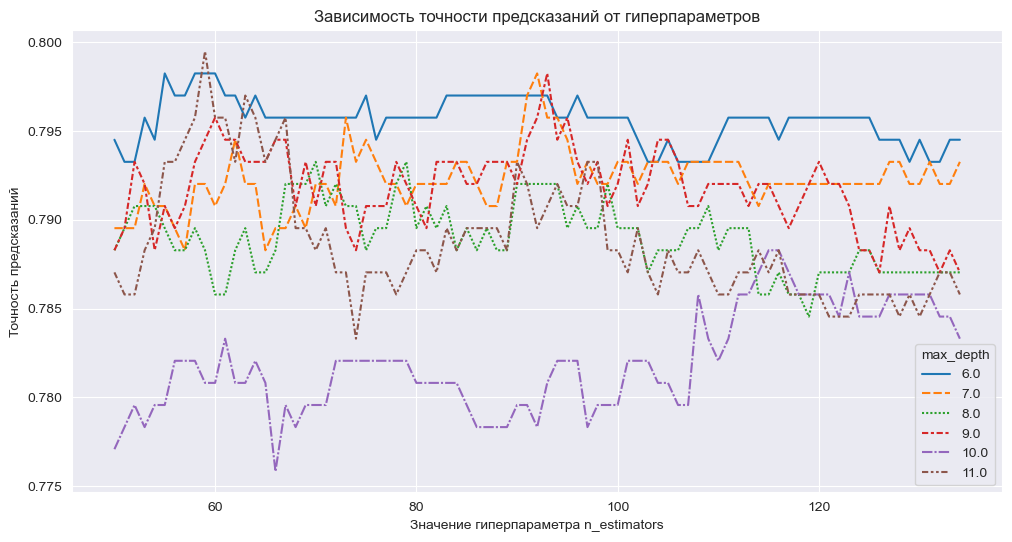

In [35]:
plt.figure(figsize=(12,6))
sns.set_style("darkgrid")
sns.lineplot(data =metrics_rf_wide)
plt.title('Зависимость точности предсказаний от гиперпараметров')
plt.xlabel('Значение гиперпараметра n_estimators')
plt.ylabel('Точность предсказаний')
plt.grid(True)
plt.show()

In [26]:
#дообучим модель на валидацционной выборке
features_train_valid = pd.concat([features_train, features_valid], ignore_index=True)
target_train_valid = pd.concat([target_train, target_valid], ignore_index=True)
display(features_train_valid.shape, target_train_valid.shape)
model_forest_selected = RandomForestClassifier(criterion='entropy', random_state=12345, n_estimators=best_est, max_depth=best_max_depth, n_jobs=-1)
model_forest_selected.fit(features_train_valid,target_train_valid)

(2903, 3)

(2903,)

RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=6,
                       n_jobs=-1, random_state=12345)

#### Опробуем случайный поиск в широком диапазоне значений

#### Модель логистическая регрессия LogisticRegression 

In [48]:
model_logistic = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_logistic.fit(features_train, target_train)
predictions = model_logistic.predict(features_valid) # получите предсказания модели
result = accuracy_score(target_valid, predictions) # посчитайте качество модели
print("Accuracy модели LogisticRegression на валидационной выборке:", result)

Accuracy модели LogisticRegression на валидационной выборке: 0.48194271481942713


Для данного датасета модель LogisticRegression  не работает, так как связи между таргетом и признаками нелинейные. Видимо, модель не может отделить котлеты от мух одной плоскостью

### Вывод по исследованию моделей:

Наибольшей точности получилось добиться от RandomForestClassifier. Decision tree показал результат похуже, но гораздо быстрее. После балансировки тренировочной выборки
LogisticRegression стал давать случайные ответы, и перестал давать адекватный прогноз, хотя до былансировки показывал результат около 0.72 

## Проверьте модель на тестовой выборке

#### Модель до доубученя на валидационной выборке

In [28]:
predictions = best_model_rf.predict(features_test) # получите предсказания модели
result = accuracy_score(target_test, predictions) # посчитайте качество модели
print('Accuracy наилучшей модели RandomForestClassifier на тестовой выборке:', result)

Accuracy наилучшей модели RandomForestClassifier на тестовой выборке: 0.8121890547263682


#### Модель после доубученя на валидационной выборке

In [29]:
predictions = model_forest_selected.predict(features_test) # получите предсказания модели
result = accuracy_score(target_test, predictions) # посчитайте качество модели
print('Accuracy наилучшей модели RandomForestClassifier на тестовой выборке:', result)

Accuracy наилучшей модели RandomForestClassifier на тестовой выборке: 0.8296019900497512


### Классы в тренировочной выборке были сбалансированы, что помогло избежать проблем с предсказаниями для редкого класса.

Были обучены три модели: RandomForestClassifier, DecisionTreeClassifier и LogisticRegression на тренировочной выборке. Оценка точности была проведена на валидационной выборке, и были подобраны соответствующие гиперпараметры для каждой модели.

Исходя из оценки точности на валидационной выборке, RandomForestClassifier показал лучшие результаты. Поэтому данная модель была дообучена на валидационной выборке.

После дообучения, модель RandomForestClassifier была протестирована на тестовой выборке. Тестовые результаты подтвердили хорошую точность, близкую к точности на валидационной выборке. Это говорит о стабильности модели.

RandomForestClassifier оказался наиболее эффективной моделью из всех рассмотренных в проекте. Она обладает широкими возможностями настройки гиперпараметров, что позволяет достичь более точных прогнозов, чем другие модели.

Однако, стоит отметить, что время подбора гиперпараметров значительно возросло. Подборка гиперпараметров на валидационной выборке с последующим дообучением модели на ней привело к улучшению результатов.

Важно отметить, что только RandomForestClassifier и DecisionTreeClassifier смогли преодолеть требуемый порог точности 0.75. При этом после балансировки классов в тренировочной выборке, модель LogisticRegression перестала давать адекватные прогнозы. Для данного датасета эта модель не подходит, так как связи между целевой переменной и признаками являются нелинейными.

💡 Данные выводы позволяют нам заключить, что модель RandomForestClassifier, после настройки гиперпараметров и дообучения, является оптимальным выбором для классификации тарифов на основе поведения клиентов.

## (бонус) Проверьте модели на адекватность

In [30]:
target_train_valid.value_counts()

0    1671
1    1232
Name: is_ultra, dtype: int64

In [31]:
target_test.value_counts()

0    558
1    246
Name: is_ultra, dtype: int64

In [32]:
clf_dummy = DummyClassifier(random_state=12345) 
#establishing random_state for reproducibility
clf_dummy.fit(features_train_valid, target_train_valid)
resultat_dummy= clf_dummy.score(features_test, target_test)
print(resultat_dummy)

0.6940298507462687


После получения результата адекватности модели, равному 0.6890547263681592, при результате лучшей модели 0.8171641791044776 попробуем сбалансировать таргет